## Классификация RUL (Deep Learning)

DONE:
- LSTM
- CNN 
    - реккурентные графики
    - Gramian Angular Fields
    

#### Импорт библиотек

In [8]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
import itertools
from time import time

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

from tensorflow import GradientTape
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")

#### Чтение данных

In [65]:
df = pd.read_parquet('data/train_data.parquet')

In [66]:
test = pd.read_parquet('data/test_data.parquet')

In [6]:
df_feat = pd.read_parquet('data/train_data_feat.parquet')

In [7]:
test_feat = pd.read_parquet('data/test_data_feat.parquet')

#### Чтение изображений

In [27]:
xtrain_rec = np.load('data/xtrain_img_rec.npy')
xtest_rec = np.load('data/xtest_img_rec.npy')

xtrain_gaf = np.load('data/xtrain_img_gaf.npy')
xtest_gaf = np.load('data/xtest_img_gaf.npy')

Отшкалируем данные и удалим наны

In [10]:
# params = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#        's15', 's16', 's17', 's18', 's19', 's20', 's21']
# noninform_feat = ['s19', 's18', 's16', 's10', 's5', 's6', 's1', 'setting1', 'setting2', 'setting3']

# параметры отобранные анализом данных
params = ['setting1', 'setting2', 's2', 's3', 's4', 's7', 
          's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
          's20', 's21']

# параметры отобранные случайным лесом
feat_imp = pd.read_parquet('data/feature_imp_class.parquet')
params_imp = feat_imp.feature[:50]

In [11]:
scaler = StandardScaler()
df[params] = scaler.fit_transform(df[params])

In [12]:
test[params] = scaler.fit_transform(test[params])

In [13]:
df_feat[params_imp] = scaler.fit_transform(df_feat[params_imp])

In [14]:
test_feat[params_imp] = scaler.fit_transform(test_feat[params_imp])

### Нейронные сети

#### Рекуррентные нейронные сети 

In [74]:
xtrain = np.load('data/xtrain.npy')
xtest = np.load('data/xtest.npy')

ytrain = np.load('data/ytrain.npy')
ytest = np.load('data/ytest.npy')

xtrain_feat = np.load('data/xtrain_feat.npy')
xtest_feat = np.load('data/xtest_feat.npy')

In [86]:
def LSTM_NN(params):
    LAYERS = [8, 8, 8, 3]  # число юнитов в слоях              
    seq_len = 50

    model = Sequential()
    model.add(LSTM(input_shape=(seq_len, len(params)), 
                   units=LAYERS[0],
                   activation='tanh', 
                   recurrent_activation='hard_sigmoid',
                   kernel_regularizer=l2(3e-2), 
                   recurrent_regularizer=l2(3e-2),
                   return_sequences=True, return_state=False,
                   stateful=False, unroll=False ))
    model.add(BatchNormalization())
    model.add(LSTM(units=LAYERS[1],
                   activation='tanh', 
                   recurrent_activation='hard_sigmoid',
                   kernel_regularizer=l2(3e-2), 
                   recurrent_regularizer=l2(3e-2),
                   return_sequences=True, return_state=False,
                   stateful=False, unroll=False ))
    model.add(BatchNormalization())
    model.add(LSTM(units=LAYERS[2],
                   activation='tanh', 
                   recurrent_activation='hard_sigmoid',
                   kernel_regularizer=l2(3e-2), 
                   recurrent_regularizer=l2(3e-2),
                   return_sequences=False, return_state=False,
                   stateful=False, unroll=False ))
    model.add(BatchNormalization())
    model.add(Dense(units=LAYERS[3], activation='sigmoid'))


    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(lr=0.01))
    
    print(model.summary())
    return model

In [87]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

In [88]:
BATCH_SIZE = 400
EPOCHS = 20

model = LSTM_NN(params)

History = model.fit(np.asarray(xtrain), np.asarray(ytrain),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 50, 8)             800       
_________________________________________________________________
batch_normalization_18 (Batc (None, 50, 8)             32        
_________________________________________________________________
lstm_19 (LSTM)               (None, 50, 8)             544       
_________________________________________________________________
batch_normalization_19 (Batc (None, 50, 8)             32        
_________________________________________________________________
lstm_20 (LSTM)               (None, 8)                 544       
_________________________________________________________________
batch_normalization_20 (Batc (None, 8)                 32        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

In [83]:
model.evaluate(xtest, ytest, verbose=0)[1]

0.8985951

In [92]:
lstm_ypred = model.predict_classes(xtest)

In [93]:
print(classification_report(np.where(ytest != 0)[1], lstm_ypred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      6922
           1       0.61      0.83      0.70      1180
           2       0.26      1.00      0.41        60

    accuracy                           0.90      8162
   macro avg       0.62      0.91      0.69      8162
weighted avg       0.93      0.90      0.91      8162



In [94]:
confusion_matrix(np.where(ytest != 0)[1], lstm_ypred)

array([[6308,  614,    0],
       [  34,  976,  170],
       [   0,    0,   60]], dtype=int64)

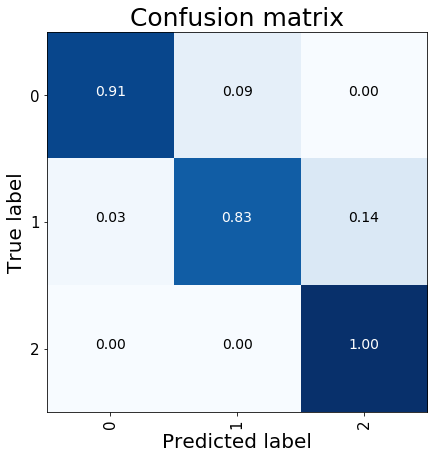

In [95]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], lstm_ypred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

#### Сверточные нейронные сети (СNN)

In [112]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(50,50,len(params)), name='layer_conv1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool1'))
model.add(Dropout(0.25, name='drop1'))

model.add(Conv2D(64, (3,3), activation='relu', name='layer_conv3'))
model.add(Conv2D(64, (3,3), activation='relu', name='layer_conv4'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool2'))
model.add(Dropout(0.25, name='drop2'))

model.add(Flatten(name='flat1'))
model.add(Dense(256, activation='relu', name='dense1'))
model.add(Dropout(0.5, name='drop3'))
model.add(Dense(3, activation='softmax', name='dense2'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 48, 48, 32)        4640      
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 23, 23, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 23, 23, 32)        0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 21, 21, 64)        18496     
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 9, 9, 64)        

In [113]:
BATCH_SIZE = 200
EPOCHS = 10

history = model.fit(xtrain_rec,
                   ytrain,
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS,
                   validation_split=0.2,
                   verbose=1)

Train on 12504 samples, validate on 3127 samples
Epoch 1/10
12504/12504 [==============================] - 130s 10ms/sample - loss: 1.1216 - acc: 0.7058 - val_loss: 0.3844 - val_acc: 0.8411
Epoch 2/10
12504/12504 [==============================] - 155s 12ms/sample - loss: 0.3675 - acc: 0.8450 - val_loss: 0.3341 - val_acc: 0.8462
Epoch 3/10
12504/12504 [==============================] - 131s 10ms/sample - loss: 0.3296 - acc: 0.8596 - val_loss: 0.3571 - val_acc: 0.8452
Epoch 4/10
12504/12504 [==============================] - 126s 10ms/sample - loss: 0.3154 - acc: 0.8620 - val_loss: 0.3383 - val_acc: 0.8638
Epoch 5/10
12504/12504 [==============================] - 125s 10ms/sample - loss: 0.2704 - acc: 0.8832 - val_loss: 0.3223 - val_acc: 0.8689
Epoch 6/10
12504/12504 [==============================] - 125s 10ms/sample - loss: 0.2458 - acc: 0.8949 - val_loss: 0.3060 - val_acc: 0.8756
Epoch 7/10
12504/12504 [==============================] - 123s 10ms/sample - loss: 0.2124 - acc: 0.9096 -

In [114]:
model.evaluate(xtest_rec, ytest, verbose=0)[1]

0.82357264

In [115]:
rec_ypred = model.predict_classes(xtest_rec)

In [116]:
print(classification_report(np.where(ytest != 0)[1], rec_ypred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      6922
           1       0.44      0.79      0.56      1180
           2       0.35      0.87      0.50        60

    accuracy                           0.82      8162
   macro avg       0.59      0.83      0.65      8162
weighted avg       0.89      0.82      0.84      8162



In [117]:
confusion_matrix(np.where(ytest != 0)[1], rec_ypred)

array([[5736, 1186,    0],
       [ 149,  934,   97],
       [   0,    8,   52]], dtype=int64)

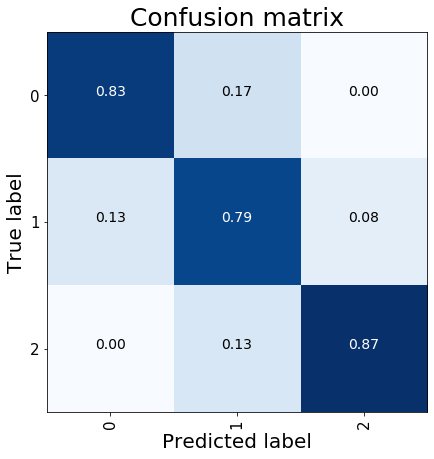

In [118]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], rec_ypred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

Gramian Angular Field

In [104]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(50,50,len(params)), name='layer_conv1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool1'))
model.add(Dropout(0.25, name='drop1'))

model.add(Conv2D(64, (3,3), activation='relu', name='layer_conv3'))
model.add(Conv2D(64, (3,3), activation='relu', name='layer_conv4'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool2'))
model.add(Dropout(0.25, name='drop2'))

model.add(Flatten(name='flat1'))
model.add(Dense(256, activation='relu', name='dense1'))
model.add(Dropout(0.5, name='drop3'))
model.add(Dense(3, activation='softmax', name='dense2'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [105]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 48, 48, 32)        4640      
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 23, 23, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 23, 23, 32)        0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 21, 21, 64)        18496     
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 9, 9, 64)        

In [106]:
BATCH_SIZE = 200
EPOCHS = 10

history = model.fit(xtrain_gaf,
                   ytrain,
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS,
                   validation_split=0.2,
                   verbose=1)

Train on 12504 samples, validate on 3127 samples
Epoch 1/10
12504/12504 [==============================] - 146s 12ms/sample - loss: 0.7772 - acc: 0.6541 - val_loss: 0.5706 - val_acc: 0.7547
Epoch 2/10
12504/12504 [==============================] - 128s 10ms/sample - loss: 0.4765 - acc: 0.7945 - val_loss: 0.4050 - val_acc: 0.8318
Epoch 3/10
12504/12504 [==============================] - 131s 11ms/sample - loss: 0.4070 - acc: 0.8282 - val_loss: 0.4037 - val_acc: 0.8331
Epoch 4/10
12504/12504 [==============================] - 126s 10ms/sample - loss: 0.3359 - acc: 0.8634 - val_loss: 0.3273 - val_acc: 0.8647
Epoch 5/10
12504/12504 [==============================] - 125s 10ms/sample - loss: 0.2831 - acc: 0.8878 - val_loss: 0.3159 - val_acc: 0.8663
Epoch 6/10
12504/12504 [==============================] - 128s 10ms/sample - loss: 0.2768 - acc: 0.8893 - val_loss: 0.2894 - val_acc: 0.8772
Epoch 7/10
12504/12504 [==============================] - 124s 10ms/sample - loss: 0.2122 - acc: 0.9154 -

In [107]:
model.evaluate(xtest_gaf, ytest, verbose=0)[1]

0.7880421

In [108]:
gaf_ypred = model.predict_classes(xtest_gaf)

In [109]:
print(classification_report(np.where(ytest != 0)[1], gaf_ypred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      6922
           1       0.38      0.73      0.50      1180
           2       0.17      0.80      0.28        60

    accuracy                           0.79      8162
   macro avg       0.51      0.78      0.55      8162
weighted avg       0.89      0.79      0.82      8162



In [110]:
confusion_matrix(np.where(ytest != 0)[1], gaf_ypred)

array([[5524, 1378,   20],
       [ 102,  860,  218],
       [   5,    7,   48]], dtype=int64)

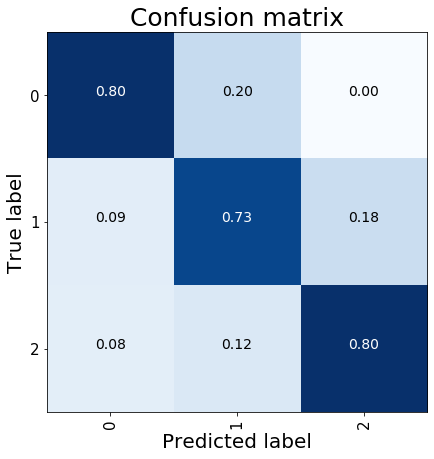

In [111]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], gaf_ypred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

Визуализация фильтров

In [75]:
layer_variables = model.get_layer('conv2d_4').get_weights()

weights = layer_variables[0]
biases = layer_variables[1]

w = np.array(weights)
w.shape

(3, 3, 16, 32)

In [76]:
w = np.moveaxis(w, 2, 0)
w = np.moveaxis(w, 3, 0)
print(w.shape)

(32, 16, 3, 3)


In [77]:
w.shape[1]

16

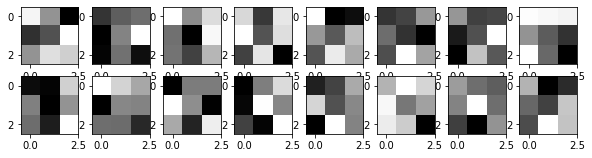

In [78]:


# the total filter in previous layers will be obtained from w.shape[1]
total_filters_in_prev_layers = 16

cols = 8
rows = 8
# rows * cols > total_filters

# current_filter = which filter's weights we want to see
current_filter = 10

fig = plt.figure(figsize=(10, 10))

for each_depth in range(w.shape[1]):
    fig.add_subplot(rows, cols, each_depth+1)
    plt.imshow(w[current_filter][each_depth], cmap='gray')

In [108]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(xtrain_img[10].reshape(1,50,50,len(params)))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

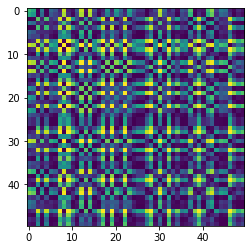

In [109]:
plt.imshow(xtrain_img[10][:,:,0])

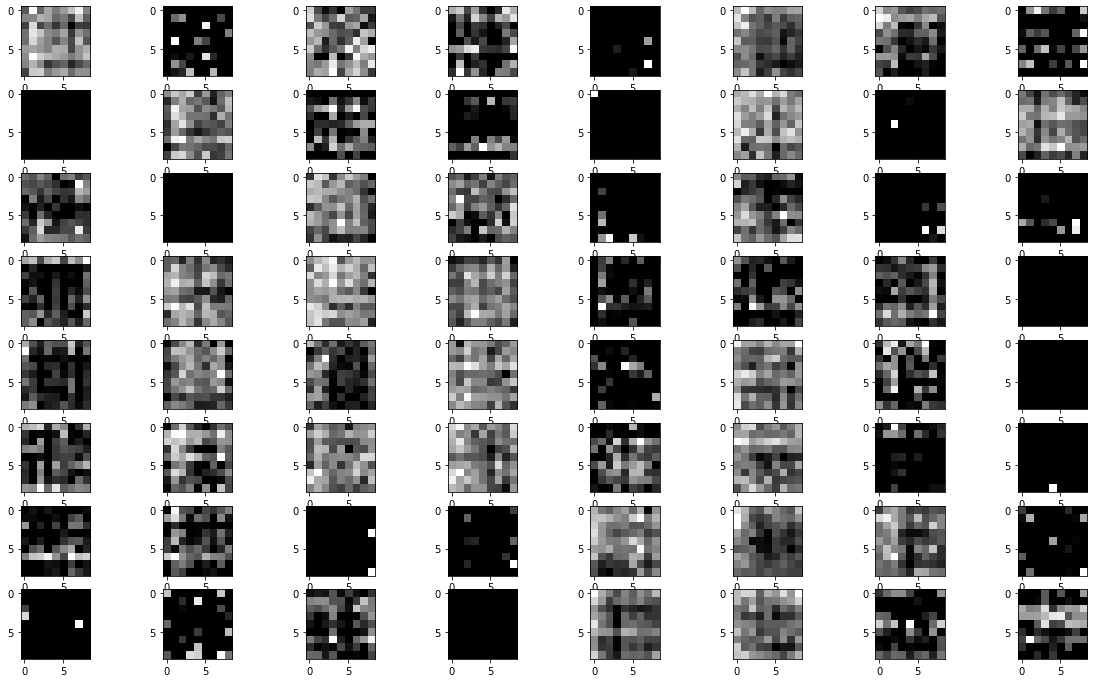

In [114]:
display_activation(activations, 8, 8, 6)

#### Приложение

In [43]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)